<a href="https://colab.research.google.com/github/dansecret/Deep_Learning/blob/main/LabDL_03_CNN_Praktikan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab DL 03: Convolutional Neural Networks
Nama : Hamdandih

NIM  : 2000018350

# **1. Introduction**

This lab work shows how to classify images in CIFAR-10 dataset. It builds an image classifier using a `tf.keras.Sequential` model and load data using `tf.keras.preprocessing.image.ImageDataGenerator`. You will get some practical experience and develop intuition for the following concepts:

* Building _data input pipelines_ using the `tf.keras.preprocessing.image.ImageDataGenerator` class to efficiently work with data on disk to use with the model.
* _Overfitting_ —How to identify and prevent it.
* _Data augmentation_ and _dropout_ —Key techniques to fight overfitting in computer vision tasks to incorporate into the data pipeline and image classifier model.

This lab work follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

# **2. Mounting Google Drive**

In [1]:
from google.colab import drive
from os.path import join, exists

# mounting dataset dari gdrive
drive.mount('/content/gdrive', force_remount=True)

# folder ini juga digunakan untuk menyimpan model yang sudah dilatih
root_path = 'gdrive/My Drive/Colab Notebooks/Deep Learning Labs/LabDL03 Data/'

# opsional - tampilkan info lokasi dataset
print("Path root:", root_path)

Mounted at /content/gdrive
Path root: gdrive/My Drive/Colab Notebooks/Deep Learning Labs/LabDL03 Data/


# **3. Download Dataset**
Kita menggunakan CIFAR-10 Dataset yang terdiri 10 kelas.

In [2]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

# download Cifar-10 dataset
(X_data, y_data), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# kategori pada dataset
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# bagi data latih untuk mendapatkan data validasi dengan rasio 70% - 30%
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, 
                                                  test_size=0.3, 
                                                  random_state=42)

y_train = y_train.ravel()
y_val = y_val.ravel()
y_test = y_test.ravel()

# tampilkan informasi dataset
num_class = len(class_names)

print('Jumlah kelas:', num_class)
print('Label kelas:', class_names)
print('Dimensi data latih:', X_train.shape)
print('Dimensi data validasi:', X_val.shape)
print('Dimensi data uji:', X_test.shape)

170498071/170498071 [==============================] - 2s 0us/step
Jumlah kelas: 10
Label kelas: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Dimensi data latih: (35000, 32, 32, 3)
Dimensi data validasi: (15000, 32, 32, 3)
Dimensi data uji: (10000, 32, 32, 3)


## Visualisasi data

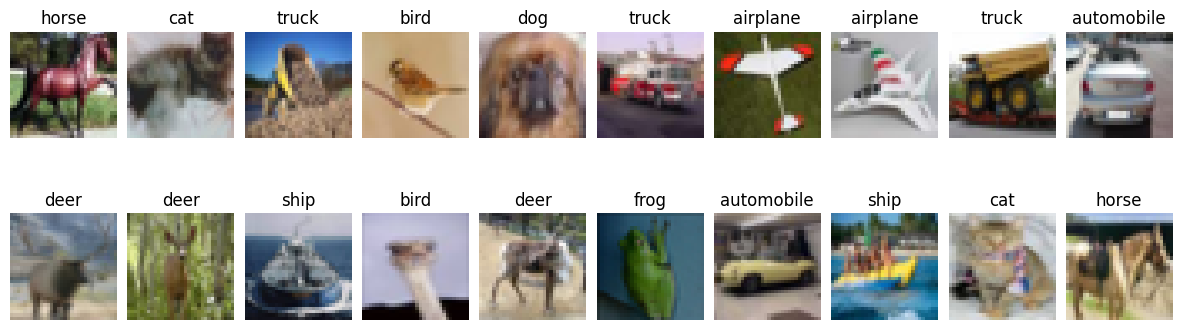

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline

fig, ax = plt.subplots(2,10,figsize=(15,4.5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for j in range(0,2):
    for i in range(0, 10):
        ax[j,i].imshow(X_train[i+j*10])
        ax[j,i].set_title(class_names[y_train[i+j*10]])
        ax[j,i].axis('off')
plt.show()

## Persiapkan dataset
Format the images into appropriately pre-processed floating point tensors before feeding to the network:

1. Read images from the disk.
2. Decode contents of these images and convert it into proper grid format as per their RGB content.
3. Convert them into floating point tensors.
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values. It's important that the training set and the testing set are preprocessed in the same way.

Fortunately, all these tasks can be done with the `ImageDataGenerator` class provided by `tf.keras`. It can read images from disk and preprocess them into proper tensors. It will also set up generators that convert these images into batches of tensors—helpful when training the network.

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# input citra
input_size = (X_train[0].shape[0], X_train[0].shape[1], 3)

# ukuran batch
batch_size = 128

# inisialisasi generator data latih dengan augmentasi data
train_image_generator = ImageDataGenerator(rescale=1./255)

# inisialisasi generator data validasi
val_image_generator = ImageDataGenerator(rescale=1./255)  

 # inisialisasi generator data uji
test_data_generator = ImageDataGenerator(rescale=1./255)

# buat generator data latih
train_data_gen = train_image_generator.flow(X_train, y_train, 
                                            batch_size=batch_size, 
                                            shuffle=True)
# buat generator data validasi                                
val_data_gen = val_image_generator.flow(X_val, y_val, 
                                        batch_size=batch_size, 
                                        shuffle=True)
# buat generator data uji
test_data_gen = test_data_generator.flow(X_test, y_test, 
                                         batch_size=1, 
                                         shuffle=True)

# **4. Membangun Model CNN**

A simple ConvNet is a sequence of layers, and every layer of a ConvNet transforms one volume of activations to another through a differentiable function. We use three main types of layers to build ConvNet architectures: **Convolutional Layer, Pooling Layer, and Fully-Connected Layer** (exactly as seen in regular Neural Networks). We will stack these layers to form a full ConvNet architecture.


## **CNN Model**
We will go into more details below, but a simple ConvNet for CIFAR-10 classification could have the architecture 
`[INPUT - CONV - RELU - POOL - FC]`

In more detail:

1. **INPUT** [32x32x3] 
will hold the raw pixel values of the image, in this case an image of width 32, height 32, and with three color channels R,G,B.
2. **CONV layer** 
will compute the output of neurons that are connected to local regions in the input, each computing a dot product between their weights and a small region they are connected to in the input volume. This may result in volume such as [32x32x12] if we decided to use 12 filters.

<table>
  <tr><td  align="center">
    <img src="https://miro.medium.com/max/960/1*bx3kWA2cKm14OrNP1M-6gw.gif" width="80%" 
         alt="Convolution Process">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1:</b> Convolution Process.<br/>
  </td></tr>
</table>

3. **RELU layer** 
will apply an elementwise activation function, such as the max(0,x) thresholding at zero. This leaves the size of the volume unchanged ([32x32x12]).
4. **POOL layer** 
will perform a downsampling operation along the spatial dimensions (width, height), resulting in volume such as [16x16x12].
5. **FC (i.e. fully-connected) layer** 
will compute the class scores, resulting in volume of size [1x1x10], where each of the 10 numbers correspond to a class score, such as among the 10 categories of CIFAR-10. As with ordinary Neural Networks and as the name implies, each neuron in this layer will be connected to all the numbers in the previous volume.

In this way, ConvNets transform the original image layer by layer from the original pixel values to the final class scores. Note that some layers contain parameters and other don’t. In particular, the CONV/FC layers perform transformations that are a function of not only the activations in the input volume, but also of the parameters (the weights and biases of the neurons). 

On the other hand, the RELU/POOL layers will implement a fixed function. The parameters in the CONV/FC layers will be trained with gradient descent so that the class scores that the ConvNet computes are consistent with the labels in the training set for each image.

## Contoh Model CNN

In [5]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, Dense
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import MaxPooling2D, Activation, Flatten
from tensorflow.keras.optimizers import Adam

## Buat model CNN dengan konfigurasi sebagai berikut:

**Convolutional block 1**
- conv layer dengan jumlah filter = 32, ukuran filter = 3x3, fungsi aktivasi relu
- conv layer dengan jumlah filter = 32, ukuran filter = 3x3, fungsi aktivasi relu
- max pooling layer dengan pooling size 2x2

**Convolutional block 2**
- conv layer dengan jumlah filter = 64, ukuran filter = 3x3, fungsi aktivasi relu
- conv layer dengan jumlah filter = 64, ukuran filter = 3x3, fungsi aktivasi relu
- max pooling layer dengan pooling size 2x2

**Convolutional block 2**
- conv layer dengan jumlah filter = 128, ukuran filter = 3x3, fungsi aktivasi relu
- conv layer dengan jumlah filter = 128, ukuran filter = 3x3, fungsi aktivasi relu
- max pooling layer dengan pooling size 2x2

**Flatten**

**Fully connected layer**
- Dense dengan jumlah neuron 128 dan fungsi aktivasi relu

**Output layer**
- Dense dengan jumlah neuron sejumlah kategori dari dataset CIFAR-10 dan fungsi aktivasi softmax

In [6]:
cnn_model1 = Sequential() 

# the first convolutional block
cnn_model1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_size))  
cnn_model1.add(Conv2D(32, (3, 3), padding='same', activation='relu')) 
# max pooling
cnn_model1.add(MaxPooling2D(pool_size=(2, 2))) 

# the second convolutional block
cnn_model1.add(Conv2D(64, (3, 3), padding='same', activation='relu')) 
cnn_model1.add(Conv2D(64, (3, 3), padding='same', activation='relu')) 
# max pooling
cnn_model1.add(MaxPooling2D(pool_size=(2, 2)))

# the third convolutional block
cnn_model1.add(Conv2D(128, (3, 3), padding='same', activation='relu')) 
cnn_model1.add(Conv2D(128, (3, 3), padding='same', activation='relu')) 
# max pooling
cnn_model1.add(MaxPooling2D(pool_size=(2, 2))) 

# flatten
cnn_model1.add(Flatten()) 

# fully connected layer
cnn_model1.add(Dense(128, activation='relu')) 

# last layer
cnn_model1.add(Dense(num_class, activation='softmax'))

### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

*Loss function* — This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.

*Optimizer* — This is how the model is updated based on the data it sees and its loss function.

*Metrics* — Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.

For this tutorial we choose *ADAM* optimizer and *binary cross entropy* loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [7]:
# Path to save the best model.
checkpoint_filepath = join(root_path, 'cnn_model1.h5')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, save_weights_only=False,
    monitor='val_loss', verbose=1, mode='auto', save_best_only=True)

opt = keras.optimizers.Adam(learning_rate=0.0001)

cnn_model1.compile(optimizer=opt, 
                   loss='sparse_categorical_crossentropy', 
                   metrics=['accuracy'])

### Model summary

View all the layers of the network using the model's `summary` method:

In [8]:
cnn_model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                    

# **5. Pelatihan Model CNN**
Training the neural network model requires the following steps:

1. Feed the training data to the model. In this example, the training data is in the ```train_images``` and ```train_labels``` arrays.

1. The model learns to associate images and labels.

1. You ask the model to make predictions about a test set—in this example, the ```test_images``` array.

1. Verify that the predictions match the labels from the ```test_labels``` array.

To begin training, call the ```model.fit``` method — so called because it "fits" the model to the training data:

In [9]:
epochs = 5

history = cnn_model1.fit(
    train_data_gen,
    epochs=epochs,
    validation_data=val_data_gen,
    callbacks=[model_checkpoint_callback],
    verbose=1)

Epoch 1/5
274/274 [==============================] - ETA: 0s - loss: 1.9295 - accuracy: 0.3036
Epoch 1: val_loss improved from inf to 1.66222, saving model to gdrive/My Drive/Colab Notebooks/Deep Learning Labs/LabDL03 Data/cnn_model1.h5
274/274 [==============================] - 23s 31ms/step - loss: 1.9295 - accuracy: 0.3036 - val_loss: 1.6622 - val_accuracy: 0.4001
Epoch 2/5
274/274 [==============================] - ETA: 0s - loss: 1.5682 - accuracy: 0.4337
Epoch 2: val_loss improved from 1.66222 to 1.49867, saving model to gdrive/My Drive/Colab Notebooks/Deep Learning Labs/LabDL03 Data/cnn_model1.h5
274/274 [==============================] - 7s 26ms/step - loss: 1.5682 - accuracy: 0.4337 - val_loss: 1.4987 - val_accuracy: 0.4634
Epoch 3/5
274/274 [==============================] - ETA: 0s - loss: 1.4276 - accuracy: 0.4864
Epoch 3: val_loss improved from 1.49867 to 1.40343, saving model to gdrive/My Drive/Colab Notebooks/Deep Learning Labs/LabDL03 Data/cnn_model1.h5
274/274 [=======

### Visualize training results
visualize the results after training the network.

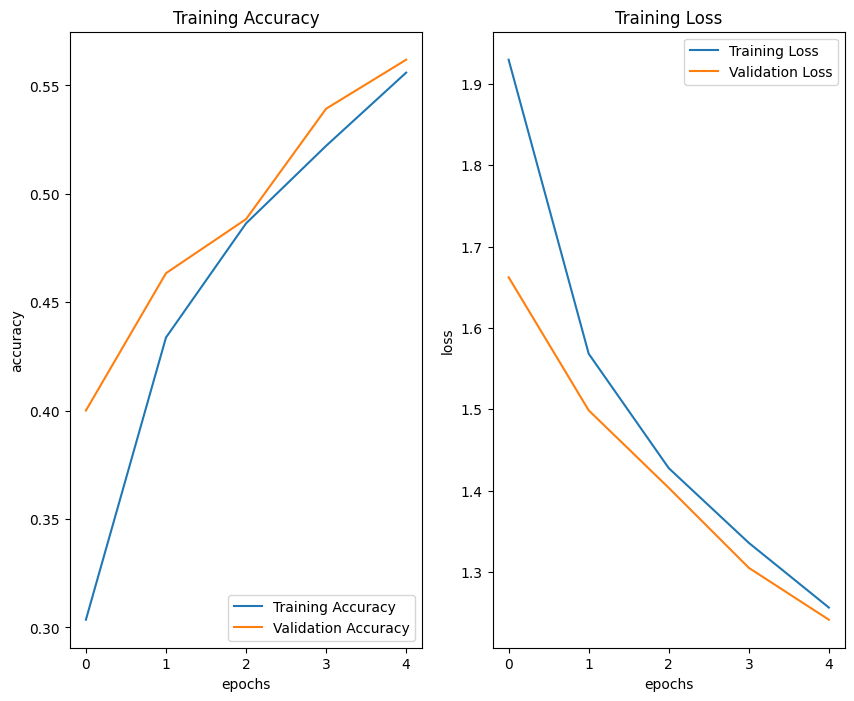

In [10]:
# ambil statistik pelatihan
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

# plot hasil akurasi pelatihan
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('accuracy') 
plt.xlabel('epochs')
plt.title('Training Accuracy')

# plot hasil loss pelatihan
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('loss') 
plt.xlabel('epochs')
plt.title('Training Loss')
plt.show()

As you can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around **70%** accuracy on the validation set.

This gap between training accuracy and test accuracy represents overfitting. Overfitting is when a machine learning model performs worse on new, previously unseen inputs than on the training data. 

An overfitted model "memorizes" the training data—with less accuracy on testing data.

Let's look at what went wrong and try to increase overall performance of the model.

# **6. Managing Overfitting**
In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 70% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of *overfitting*.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *dropout* to our model.

## Data augmentation
Overfitting generally occurs when there are a small number of training examples. One way to fix this problem is to augment the dataset so that it has a sufficient number of training examples. Data augmentation takes the approach of generating more training data from existing training samples by augmenting the samples using random transformations that yield believable-looking images. The goal is the model will never see the exact same picture twice during training. This helps expose the model to more aspects of the data and generalize better.

Implement this in `tf.keras` using the `ImageDataGenerator` class. Pass  different transformations to the dataset and it will take care of applying it during the training process.

### Augment and visualize data

We can use a technique called "data augmentation" to increase the size of the training set, by generating new examples from existing ones by applying random transformations (for example, rotation).

This is especially effective when working with images. For example, our training set may only contain images of cats that are right side up. If our validation set contains images of cats that are upside down, our model may have trouble classifying them correctly. 

Data augmentation is built into the ImageDataGenerator. You can specifiy different transformations, and it will take care of applying then during the training.

Begin by applying random horizontal flip augmentation to the dataset and see how individual images look like after the transformation.

### Apply horizontal flip

Pass `horizontal_flip` as an argument to the `ImageDataGenerator` class and set it to `True` to apply this augmentation.

### Randomly rotate the image

Let's take a look at a different augmentation called rotation and apply 20 degrees of rotation randomly to the training examples.

### Apply zoom augmentation

Apply a zoom augmentation to the dataset to zoom images up to 20% randomly.



In [11]:
# buat prosedur augmentasi pada data
new_train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    # width_shift_range=.1,
    # height_shift_range=.1,
    horizontal_flip=True,
    zoom_range=0.2)

# terapkan augmentasi pada data latih
new_train_data_gen = new_train_image_generator.flow(X_train, y_train, 
                                            batch_size=batch_size, 
                                            shuffle=True)

Tampilkan hasil augmentasi data

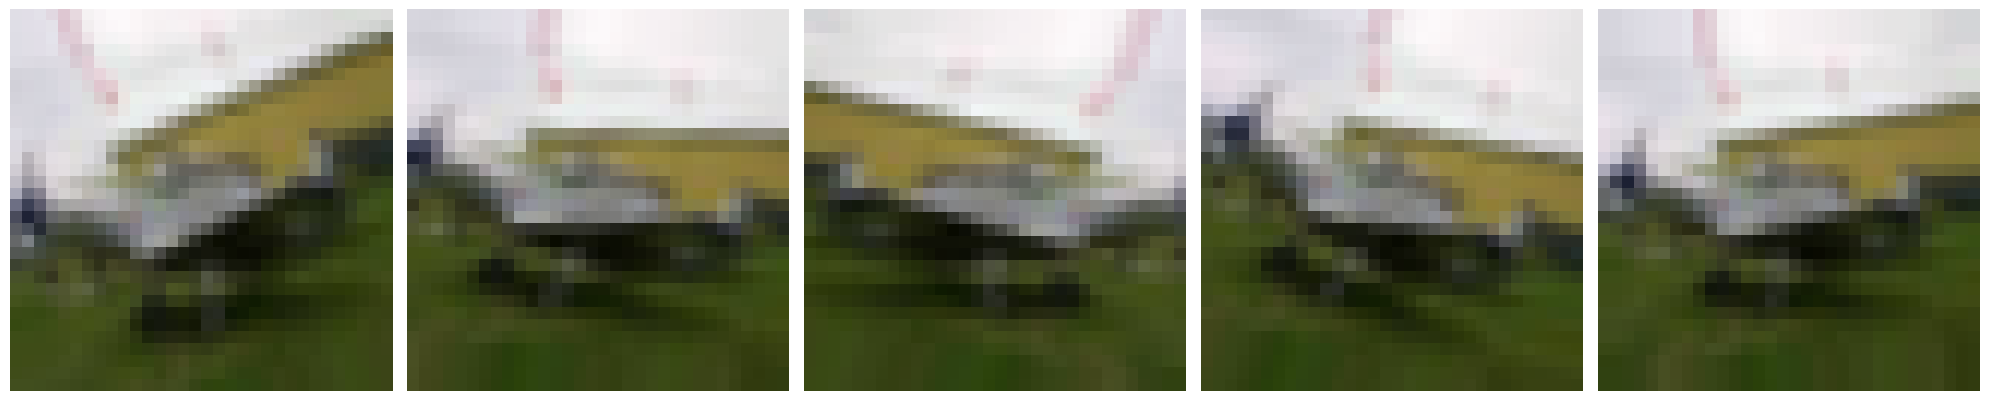

In [12]:
augmented_images = [new_train_data_gen[0][0][0] for i in range(5)]

fig, axes = plt.subplots(1, 5, figsize=(20,20))
axes = axes.flatten()
for img, ax in zip(augmented_images, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

## Dropout
Another technique to reduce overfitting is to introduce *dropout* to the network. It is a form of *regularization* that forces the weights in the network to take only small values, which makes the distribution of weight values more regular and the network can reduce overfitting on small training examples. Dropout is one of the regularization technique used in this tutorial

When you apply dropout to a layer it randomly drops out (set to zero) number of output units from the applied layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

When appling 0.1 dropout to a certain layer, it randomly kills 10% of the output units in each training epoch.

Create a network architecture with this new dropout feature and apply it to different convolutions and fully-connected layers.

# **7. Creating CNN with Dropouts and Batch Normalization**
Applying dropout will randomly set 25% of the neurons to zero during each training epoch. This helps to avoid overfitting on the training dataset.

Terapkan dropout 25% pada model cnn berikut.

In [13]:
cnn_model2 = Sequential() 

# the first convolutional block
cnn_model2.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_size))  
cnn_model2.add(BatchNormalization())
cnn_model2.add(Conv2D(32, (3, 3), padding='same', activation='relu')) 
cnn_model2.add(BatchNormalization())
# max pooling
cnn_model2.add(MaxPooling2D(pool_size=(2, 2))) 
cnn_model2.add(Dropout(0.25))

# the second convolutional block
cnn_model2.add(Conv2D(64, (3, 3), padding='same', activation='relu')) 
cnn_model2.add(BatchNormalization())
cnn_model2.add(Conv2D(64, (3, 3), padding='same', activation='relu')) 
cnn_model2.add(BatchNormalization())
# max pooling
cnn_model2.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model2.add(Dropout(0.25)) 

# the third convolutional block
cnn_model2.add(Conv2D(128, (3, 3), padding='same', activation='relu')) 
cnn_model2.add(BatchNormalization())
cnn_model2.add(Conv2D(128, (3, 3), padding='same', activation='relu')) 
cnn_model2.add(BatchNormalization())
# max pooling
cnn_model2.add(MaxPooling2D(pool_size=(2, 2))) 
cnn_model2.add(Dropout(0.25))

# flatten
cnn_model2.add(Flatten()) 

# fully connected layer
cnn_model2.add(Dense(128, activation='relu')) 
cnn_model2.add(Dropout(0.25))

# last layer
cnn_model2.add(Dense(num_class, activation='softmax'))

### Compile the model
After introducing dropouts to the network, compile the model and view the layers summary.

In [14]:
# Path to save the best model.
checkpoint_filepath = join(root_path, 'cnn_model2.h5')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, save_weights_only=False,
    monitor='val_loss', verbose=1, mode='auto', save_best_only=True)

opt = keras.optimizers.Adam(learning_rate=0.0001)

cnn_model2.compile(optimizer=opt, 
                   loss='sparse_categorical_crossentropy', 
                   metrics=['accuracy'])
cnn_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

### Train the model
After successfully introducing data augmentations to the training examples and adding dropouts to the network, train this new network:

In [15]:
epochs = 5

history = cnn_model2.fit(
    new_train_data_gen, # training data yang baru setelah augmentasi
    epochs=epochs,
    validation_data=val_data_gen,
    callbacks=[model_checkpoint_callback],
    verbose=1)

Epoch 1/5
274/274 [==============================] - ETA: 0s - loss: 2.2230 - accuracy: 0.2508
Epoch 1: val_loss improved from inf to 3.86164, saving model to gdrive/My Drive/Colab Notebooks/Deep Learning Labs/LabDL03 Data/cnn_model2.h5
274/274 [==============================] - 32s 94ms/step - loss: 2.2230 - accuracy: 0.2508 - val_loss: 3.8616 - val_accuracy: 0.1333
Epoch 2/5
274/274 [==============================] - ETA: 0s - loss: 1.7730 - accuracy: 0.3520
Epoch 2: val_loss improved from 3.86164 to 1.77017, saving model to gdrive/My Drive/Colab Notebooks/Deep Learning Labs/LabDL03 Data/cnn_model2.h5
274/274 [==============================] - 26s 94ms/step - loss: 1.7730 - accuracy: 0.3520 - val_loss: 1.7702 - val_accuracy: 0.3645
Epoch 3/5
274/274 [==============================] - ETA: 0s - loss: 1.6493 - accuracy: 0.4006
Epoch 3: val_loss improved from 1.77017 to 1.49471, saving model to gdrive/My Drive/Colab Notebooks/Deep Learning Labs/LabDL03 Data/cnn_model2.h5
274/274 [======

### Visualize training results
visualize the results after training the network.

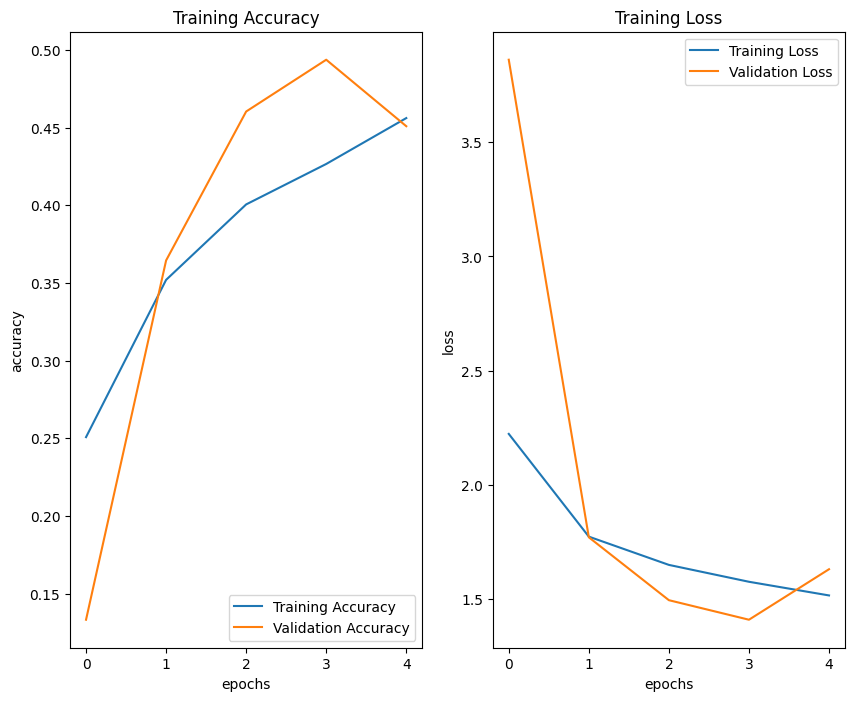

In [16]:
# ambil statistik pelatihan
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

# plot hasil akurasi pelatihan
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('accuracy') 
plt.xlabel('epochs')
plt.title('Training Accuracy')

# plot hasil loss pelatihan
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('loss') 
plt.xlabel('epochs')
plt.title('Training Loss')
plt.show()

Seperti yang anda lihat pada grafik pelatihan diatas bahwa sudah tidak terjadi overfitting dan validation loss masih turun terus dan validation akurasi masih naik terus sehingga anda dapat menambah jumlah epoch pelatihannya sampai tidak ada perubahan yang signifikan.

# **8. Model Evaluation**

In [17]:
from tensorflow.keras.models import load_model

# load hasil pelatihan untuk di uji
trained_model = load_model(checkpoint_filepath)

# pengujian dengan data uji
trained_model.evaluate(test_data_gen, verbose=1) 

10000/10000 [==============================] - 36s 4ms/step - loss: 1.3976 - accuracy: 0.4953


[1.3975530862808228, 0.4952999949455261]

## Tampilkan Hasil Pengujian

  0%|          | 0/10000 [00:00<?, ?it/s]

Output streaming akan dipotong hingga 5000 baris terakhir.
1/1 [==============================] - 0s 28ms/step


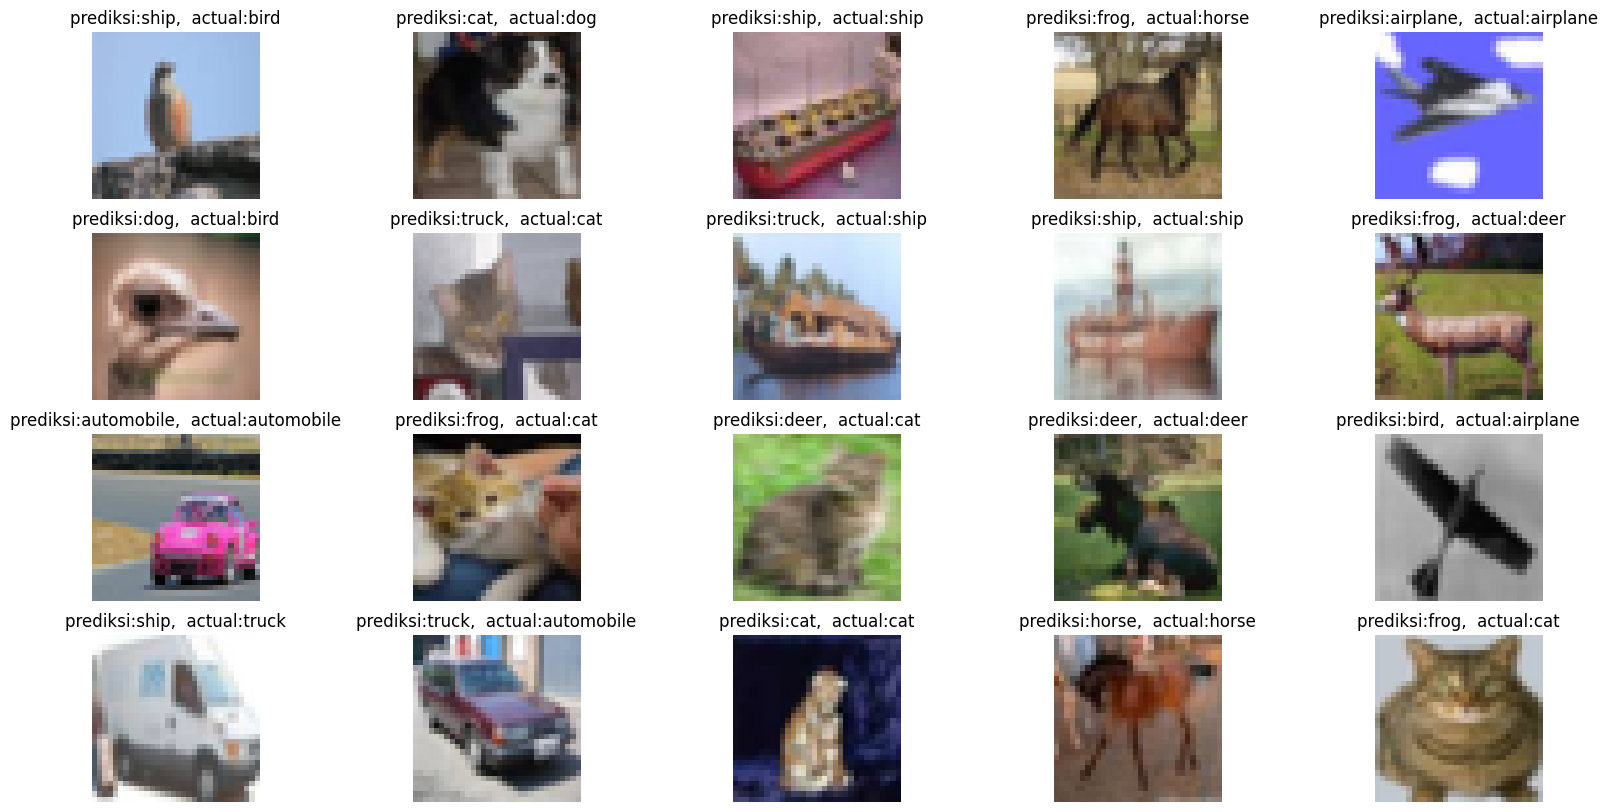

In [18]:
from tqdm.notebook import tqdm_notebook

# tampilkan misalnya 20 citra pada dataset 
nimages = 20
ncols_plot = 5
nrows_plot = nimages//ncols_plot

y_predict = []
y_actual = []
count_imgs = 0
plot_frame = plt.figure(figsize=(20,10))

# one-by-one prediction
for i in tqdm_notebook(range(len(test_data_gen))):
    imgs, labels = next(test_data_gen)
    labels = np.array(labels, dtype=np.uint8)
    for j in range(len(imgs)):
        X_batch = np.expand_dims(imgs[j], axis=0)
        prediction_scores = trained_model.predict(X_batch)
        score = np.argmax(prediction_scores)
        y_predict.append(score)
        y_actual.append(labels[j])

        # tampilkan 20 hasil pengujian
        if (count_imgs < nimages):
            ax = plot_frame.add_subplot(nrows_plot, ncols_plot, count_imgs+1)
            ax.axis('off')
            ax.set_title("prediksi:" + class_names[score] + \
                        ",  actual:" + class_names[labels[j]])
            plt.imshow(np.uint8(imgs[j]*255))
        count_imgs += 1
    
y_predict = np.array(y_predict)
y_actual = np.array(y_actual)

## Membuat Confusion Matrix

Laporan Klasifikasi Data Uji:
              precision    recall  f1-score   support

           0       0.65      0.46      0.54      1000
           1       0.55      0.63      0.59      1000
           2       0.50      0.19      0.27      1000
           3       0.41      0.24      0.30      1000
           4       0.40      0.40      0.40      1000
           5       0.53      0.35      0.42      1000
           6       0.40      0.80      0.53      1000
           7       0.56      0.53      0.55      1000
           8       0.58      0.68      0.63      1000
           9       0.48      0.68      0.56      1000

    accuracy                           0.50     10000
   macro avg       0.51      0.50      0.48     10000
weighted avg       0.51      0.50      0.48     10000

Confusion Matrix:
[[464  68  37  15  16   7  41  16 236 100]
 [ 10 626   0   2   4   0  34  10  54 260]
 [ 77  33 190  66 237  55 188  73  44  37]
 [ 17  40  32 242  73 140 304  67  25  60]
 [ 33  20  38  31 395

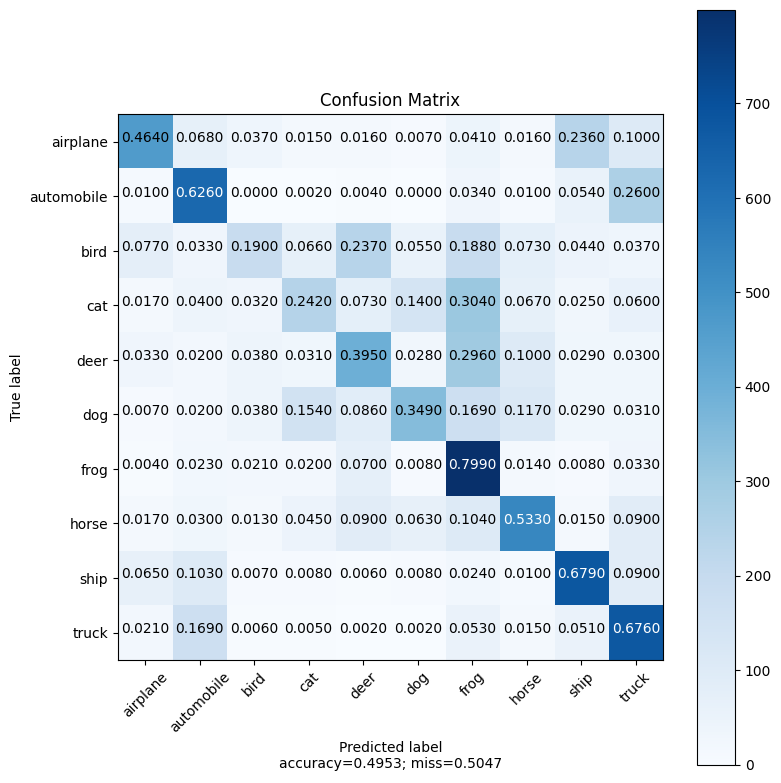

In [19]:
import itertools
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# cetak laporan hasil klasifikasi data uji
print('Laporan Klasifikasi Data Uji:')
print(classification_report(y_actual, y_predict))

# hitung confusion matrixnya
conf_mat_result = confusion_matrix(y_actual, y_predict)

# cetak confusion matrix
print('Confusion Matrix:')
print(conf_mat_result)

accuracy = np.trace(conf_mat_result) / np.sum(conf_mat_result).astype('float') 
misclass = 1 - accuracy

# masukkan nama kelas di dataset
target_names = class_names
plt.figure(figsize=(8, 8)) 
cmap = plt.get_cmap('Blues') 
  
plt.imshow(conf_mat_result, interpolation='nearest', cmap=cmap) 
plt.title('Confusion Matrix') 
plt.colorbar() 

tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45) 
plt.yticks(tick_marks, target_names)

cm = conf_mat_result.astype('float') / conf_mat_result.sum(axis=1)[:, np.newaxis] 
thresh = cm.max() / 1.5 
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, "{:0.4f}".format(cm[i, j]),
        horizontalalignment='center',
        color='white' if cm[i, j] > thresh else 'black') 

plt.tight_layout()
plt.ylabel('True label') 
plt.xlabel('Predicted label\naccuracy={:0.4f}; miss={:0.4f}'.format(accuracy, misclass)) 
plt.show() 

# **9. Post Test**
1. Copy kode di **bagian 7: Creating CNN with Dropouts and Batch Normalization** yang sudah anda perbaiki
2. Buat teks baru dibawah kode tersebut dan diberi nama **Model CNN: Post Test**
3. Buat kode baru dibawah teks tersebut lalu paste kode dari Model CNN di soal nomor 1. 
4. Ubah nama variabel model tersebut dari **cnn_model2 menjadi cnn_model_posttest**.
5. Ubah nama file untuk menyimpan model dari **cnn_model2.h5 menjadi cnn_model_posttest.h5**. 
6. **Modifikasi model CNN tersebut dan tambah jumlah epoch** sehingga anda bisa mendapatkan akurasi pelatihan, validasi dan pengujian yang lebih tinggi dari model CNN sebelumnya. 
7. Jalankan kode untuk pelatihan sampai evaluasi dengan model Post Test yang anda buat.
8. Cermati hasil akurasi pengujiannya!

**Semakin tinggi akurasi yang anda dapatkan dibandingkan dengan hasil akurasi Model CNN sebelumnya maka semakin baik nilai post test anda**

In [20]:
cnn_model_posttest = Sequential() 

# the first convolutional block
cnn_model_posttest.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_size))  
cnn_model_posttest.add(BatchNormalization())
cnn_model_posttest.add(Conv2D(32, (3, 3), padding='same', activation='relu')) 
cnn_model_posttest.add(BatchNormalization())
# max pooling
cnn_model_posttest.add(MaxPooling2D(pool_size=(2, 2))) 
cnn_model_posttest.add(Dropout(0.25))

# the second convolutional block
cnn_model_posttest.add(Conv2D(64, (3, 3), padding='same', activation='relu')) 
cnn_model_posttest.add(BatchNormalization())
cnn_model_posttest.add(Conv2D(64, (3, 3), padding='same', activation='relu')) 
cnn_model_posttest.add(BatchNormalization())
# max pooling
cnn_model_posttest.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model_posttest.add(Dropout(0.25)) 

# the third convolutional block
cnn_model_posttest.add(Conv2D(128, (3, 3), padding='same', activation='relu')) 
cnn_model_posttest.add(BatchNormalization())
cnn_model_posttest.add(Conv2D(128, (3, 3), padding='same', activation='relu')) 
cnn_model_posttest.add(BatchNormalization())
# max pooling
cnn_model_posttest.add(MaxPooling2D(pool_size=(2, 2))) 
cnn_model_posttest.add(Dropout(0.25))

# flatten
cnn_model_posttest.add(Flatten()) 

# fully connected layer
cnn_model_posttest.add(Dense(128, activation='relu')) 
cnn_model_posttest.add(Dropout(0.25))

# last layer
cnn_model_posttest.add(Dense(num_class, activation='softmax'))

In [21]:
# Path to save the best model.
checkpoint_filepath = join(root_path, 'cnn_model_posttest.h5')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, save_weights_only=False,
    monitor='val_loss', verbose=1, mode='auto', save_best_only=True)

opt = keras.optimizers.Adam(learning_rate=0.0001)

cnn_model_posttest.compile(optimizer=opt, 
                   loss='sparse_categorical_crossentropy', 
                   metrics=['accuracy'])
cnn_model_posttest.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

In [22]:
epochs = 100

history = cnn_model_posttest.fit(
    new_train_data_gen, # training data yang baru setelah augmentasi
    epochs=epochs,
    validation_data=val_data_gen,
    callbacks=[model_checkpoint_callback],
    verbose=1)

Epoch 1/100
274/274 [==============================] - ETA: 0s - loss: 2.1559 - accuracy: 0.2507
Epoch 1: val_loss improved from inf to 3.15658, saving model to gdrive/My Drive/Colab Notebooks/Deep Learning Labs/LabDL03 Data/cnn_model_posttest.h5
274/274 [==============================] - 43s 127ms/step - loss: 2.1559 - accuracy: 0.2507 - val_loss: 3.1566 - val_accuracy: 0.1019
Epoch 2/100
274/274 [==============================] - ETA: 0s - loss: 1.7903 - accuracy: 0.3518
Epoch 2: val_loss improved from 3.15658 to 1.69639, saving model to gdrive/My Drive/Colab Notebooks/Deep Learning Labs/LabDL03 Data/cnn_model_posttest.h5
274/274 [==============================] - 36s 129ms/step - loss: 1.7903 - accuracy: 0.3518 - val_loss: 1.6964 - val_accuracy: 0.3831
Epoch 3/100
274/274 [==============================] - ETA: 0s - loss: 1.6741 - accuracy: 0.3890
Epoch 3: val_loss improved from 1.69639 to 1.45088, saving model to gdrive/My Drive/Colab Notebooks/Deep Learning Labs/LabDL03 Data/cnn_m